# Chapter 6: Teaching Machines to See

## Image Classification

In this, we will train a complex convolution neural network on an image classification dataset.


<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/manning_tf2_in_action/blob/master/Ch06-Image-Classification-with-CNNs/6.1.Image_Classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>

## Importing necessary libraries

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import requests
import zipfile
import requests
import os
import time
import pandas as pd
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Dense, Concatenate, Flatten, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import numpy as np
from PIL import Image
import tensorflow.keras.backend as K
import pickle
from tensorflow.keras.models import load_model, Model

def fix_random_seed(seed):
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

random_seed = 4321
# Fixing the random seed
fix_random_seed(random_seed)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        print("Couldn't set memory_growth")
        pass

## Downloading data

For this chapter, we're going to use the tiny-imagenet dataset (200 categories of objects). This is a simplified version of the bigger and harder imagenet dataset (1000 categories of objects).

In [2]:
#Section 6.1 

import os
import requests
import zipfile

# Retrieve the data
if not os.path.exists(os.path.join('data','tiny-imagenet-200.zip')):
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    # Get the file from web
    r = requests.get(url)

    if not os.path.exists('data'):
        os.mkdir('data')
    
    # Write to a file
    with open(os.path.join('data','tiny-imagenet-200.zip'), 'wb') as f:
        f.write(r.content)
else:
    print("The zip file already exists.")
    
if not os.path.exists(os.path.join('data', 'tiny-imagenet-200')):
    with zipfile.ZipFile(os.path.join('data','tiny-imagenet-200.zip'), 'r') as zip_ref:
        zip_ref.extractall('data')
else:
    print("The extracted data already exists")

The zip file already exists.
The extracted data already exists


## Read the label information of the data

The classes in tiny-imagenet are coded by an id (known as `wnid` (WordNetID)). Here we will decode these IDs to get class descriptions of each ID, so we know what we're dealing with

In [3]:
#Section 6.1
#Code listing 6.1

import os
import pandas as pd

# The file paths we're going to use
data_dir = os.path.join('data', 'tiny-imagenet-200')
wnids_path = os.path.join(data_dir, 'wnids.txt')
words_path = os.path.join(data_dir, 'words.txt')

def get_tiny_imagenet_classes(wnids_path, words_path):
    
    # Read the csv files
    # wninds.txt contains the wnids of the data in the dataset
    wnids = pd.read_csv(wnids_path, header=None, squeeze=True)
    # words.txt contains a mapping from wnid to the class description
    words = pd.read_csv(words_path, sep='\t', index_col=0, header=None)
    # Get only the class descriptions corresponding to the wnids in the dataset
    words_200 = words.loc[wnids].rename({1:'class'}, axis=1)
    words_200.index.name = 'wnid'
    return words_200.reset_index()

labels = get_tiny_imagenet_classes(wnids_path, words_path)
labels.head(n=25)

C:\Users\carlos\AppData\Local\Temp\ipykernel_16964\4076525636.py:16: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  wnids = pd.read_csv(wnids_path, header=None, squeeze=True)


,wnid,class
0,n02124075,Egyptian cat
1,n04067472,reel
2,n04540053,volleyball
3,n04099969,"rocking chair, rocker"
4,n07749582,lemon
5,n01641577,"bullfrog, Rana catesbeiana"
6,n02802426,basketball
7,n09246464,"cliff, drop, drop-off"
8,n07920052,espresso
9,n03970156,"plunger, plumber's helper"


<a id="pgfId-1116962" href=""></a><span class="fm-combinumeral">#1</span> Imports pandas and os packages<br>
<a id="pgfId-1116986" href=""></a><span class="fm-combinumeral">#2</span> Defines paths of the data directory, wnids.txt, and words.txt files<br>
<a id="pgfId-1117003" href=""></a><span class="fm-combinumeral">#3</span> Defines a function to read the class descriptions of tiny_imagenet classes<br>
<a id="pgfId-1117020" href=""></a><span class="fm-combinumeral">#4</span> Reads wnids.txt and words.txt as CSV files using pandas<br>
<a id="pgfId-1117037" href=""></a><span class="fm-combinumeral">#5</span> Gets only the classes present in the tiny-imagenet-200 data set<br>
<a id="pgfId-1117054" href=""></a><span class="fm-combinumeral">#6</span> Sets the name of the index of the data frame to “wnid”<br>
<a id="pgfId-1117071" href=""></a><span class="fm-combinumeral">#7</span> Resets the index so that it becomes a column in the data frame (which has the column name “wnid”)<br>
<a id="pgfId-1117088" href=""></a><span class="fm-combinumeral">#8</span> Executes the function to obtain the class descriptions<br>
<a class="calibre7" id="pgfId-1117105" href=""></a><span class="fm-combinumeral">#9</span> Inspects the head of the data frame (the first 25 entries)<br>

## How many training instances for each class are there?

**Note**: If you run this after separating out the validation data, you'll see 450 instead of 500 in the `n_train` column.

In [4]:
#Section 6.1

import os
def get_image_count(data_dir):  
    """ Counts the number of jpeg files in a given folder"""
    if not os.path.exists(data_dir):
        return 0
    return len([f for f in os.listdir(data_dir) if f.lower().endswith('jpeg')])
    
# Here we use the apply function in conjunction with the get_image_count to get the count of images in each
# subfolder in the train directory
labels["n_train"] = labels["wnid"].apply(lambda x: get_image_count(os.path.join(data_dir, 'train', x, 'images')))
labels.head()

,wnid,class,n_train
0,n02124075,Egyptian cat,500
1,n04067472,reel,500
2,n04540053,volleyball,500
3,n04099969,"rocking chair, rocker",500
4,n07749582,lemon,500


## Look at summary statistics of the `n_train` column

Summary statistics is a great way to get an instant view of a column in a dataframe. It gives us important information like mean/standard deviation, etc.

In [5]:
labels["n_train"].describe()

count    200.0
mean     500.0
std        0.0
min      500.0
25%      500.0
50%      500.0
75%      500.0
max      500.0
Name: n_train, dtype: float64

## Understanding the image dimensions in the dataset

Before moving on to modelling we need to understand the image dimensions (height and width). 

<a id="pgfId-1116035" href=""></a><span class="fm-combinumeral">#1</span> Importing os, PIL, and pandas packages<br>
<a id="pgfId-1116059" href=""></a><span class="fm-combinumeral">#2</span> Defining a list to hold image sizes<br>
<a id="pgfId-1116076" href=""></a><span class="fm-combinumeral">#3</span> Looping through the first 25 classes in the data set<br>
<a id="pgfId-1116093" href=""></a><span class="fm-combinumeral">#4</span> Defining the image directory for a particular class within the loop<br>
<a id="pgfId-1116110" href=""></a><span class="fm-combinumeral">#5</span> Looping through all the images (ending with the extension JPEG) in that directory<br>
<a id="pgfId-1116127" href=""></a><span class="fm-combinumeral">#6</span> Appending the size of each image (i.e., a tuple of (width, height)) to image_sizes<br>
<a id="pgfId-1116144" href=""></a><span class="fm-combinumeral">#7</span> Creating a data frame from the tuples in the image_sizes<br>
<a id="pgfId-1116161" href=""></a><span class="fm-combinumeral">#8</span> Setting column names appropriately<br>
<a class="calibre7" id="pgfId-1116178" href=""></a><span class="fm-combinumeral">#9</span> Obtaining the summary statistics of width and height for the images we fetched<br>

In [6]:
#Section 6.1
#Code listing 6.2

import os
from PIL import Image
import pandas as pd

# A list that will hold image height and width information
image_sizes = []

# We will only look at the first 25 directories (to save time)
for wnid in labels["wnid"].iloc[:25]:
    img_dir = os.path.join('data', 'tiny-imagenet-200', 'train', wnid, 'images')
    for f in os.listdir(img_dir):
        # Only read the file if ends with JPEG
        if f.endswith('JPEG'):
            # Append the height and width to the list
            # e.g. [(img1.width, img1.height), (img2.width, img2.height), ...]
            image_sizes.append(Image.open(os.path.join(img_dir, f)).size)

# Using the format of image_sizes, we can directly create a dataframe
img_df = pd.DataFrame.from_records(image_sizes)
img_df.columns = ["width", "height"]
# Getting summary statistics of all columns
img_df.describe()

,width,height
count,12500.0,12500.0
mean,64.0,64.0
std,0.0,0.0
min,64.0,64.0
25%,64.0,64.0
50%,64.0,64.0
75%,64.0,64.0
max,64.0,64.0


## Bonus: Getting information about pixel values of the images

In [7]:
import os
import numpy as np
from PIL import Image
images = []
for wnid in labels["wnid"].iloc[:2]:
    img_dir = os.path.join('data', 'tiny-imagenet-200', 'train', wnid, 'images')
    for f in os.listdir(img_dir)[:10]:
        if f.endswith('JPEG'):
            img = np.array(Image.open(os.path.join(img_dir, f)))
            images.append((img.min(), img.max(), img.mean()))

img_df = pd.DataFrame.from_records(images)
img_df.columns = ["Min", "Max", "Mean"]
img_df.describe()

,Min,Max,Mean
count,20.000000,20.000000,20.000000
mean,2.100000,-1.350000,121.372945
std,7.383481,1.565248,40.301543
min,0.000000,-8.000000,63.183757
25%,0.000000,-1.000000,98.160726
50%,0.000000,-1.000000,112.580322
75%,0.000000,-1.000000,127.742086
max,32.000000,-1.000000,227.127360


## Creating the data generators

In the dataset, we currently have a,

* Training set: `train` directory
* Testing set: `val` directory

But to properly train a model we need three datasets,

* Training set - Used to train the model
* Validation set - Used to continuously monitor model performance while training
* Testing set - Used to test the model, only after training finishes

Therefore, we will separate a 10% from training data and feed this data through as a separate generator

In [8]:
#Section 6.2

from functools import partial

def get_test_labels_df(test_labels_path):
    """ Reading the test data labels for all files in the test set as a data frame """
    test_df = pd.read_csv(test_labels_path, sep='\t', index_col=None, header=None)
    test_df = test_df.iloc[:,[0,1]].rename({0:"filename", 1:"class"}, axis=1)
    return test_df

def get_train_valid_test_data_generators(batch_size, target_size):
    # Define a Keras ImageDataGenerator with image centering (subtract mean)
    
    image_gen = ImageDataGenerator(samplewise_center=True, validation_split=0.1)

    # Define a training data generator
    partial_flow_func = partial(
        image_gen.flow_from_directory, 
        directory=os.path.join('data','tiny-imagenet-200', 'train'), 
        target_size=target_size, classes=None,
        class_mode='categorical', batch_size=batch_size, 
        shuffle=True, seed=random_seed)
    
    # Get the training data subset
    train_gen = partial_flow_func(subset='training')
    # Get the validation data subset
    valid_gen = partial_flow_func(subset='validation')
    
    
    # Define a testing data generator
    # This function uses flow_from_dataframe instead of flow_from_directory
    test_df = get_test_labels_df(os.path.join('data','tiny-imagenet-200',  'val', 'val_annotations.txt'))
    test_gen = image_gen.flow_from_dataframe(
        test_df, directory=os.path.join('data','tiny-imagenet-200',  'val', 'images'), target_size=target_size, classes=None,
        class_mode='categorical', batch_size=batch_size, shuffle=False
    )
    return train_gen, valid_gen, test_gen

def data_gen_aux(gen):    
    # We need to modify our standard data generators to output the same target three times
    for x,y in gen:        
        yield x,(y,y,y)

batch_size = 128
target_size = (56, 56)
# Getting the train,valid, test data generators
train_gen, valid_gen, test_gen = get_train_valid_test_data_generators(batch_size, target_size)
# Modifying the data generators to fit the model targets
train_gen_aux = data_gen_aux(train_gen)
valid_gen_aux = data_gen_aux(valid_gen)
test_gen_aux = data_gen_aux(test_gen)

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.


## Validating the consistency of validation data

In [9]:
from itertools import tee
all_labels = []
n_trials = 10

valid_gen_test = tee(valid_gen, n_trials)

for i in range(n_trials):    
    labels = []
    for j in range(5):
        _, ohe = next(valid_gen_test[i])
        # Convert one hot encoded to class labels
        labels.append(np.argmax(ohe, axis=-1))
        
    # Concat all labels
    labels = np.reshape(np.concatenate(labels, axis=0), (1,-1))        
    all_labels.append(labels)

# Concat all labels accross all trials
all_labels = np.concatenate(all_labels, axis=0)

# Assert the labels are equal across all trials
assert np.all(np.all(all_labels == all_labels[0,:], axis=0)), "Labels across multiple trials were not equal"
print("Successful! Labels across all trials were consistent.")

Successful! Labels across all trials were consistent.


## Defining the Inception net v1

Here we will be creating the Inception net v1 model using Keras Functional API

### Funtions that encapsulate various components of the Inception net v1 model

<a id="pgfId-1115389" href=""></a><span class="fm-combinumeral">#1</span> The output of the first convolution layer<br>
<a id="pgfId-1115410" href=""></a><span class="fm-combinumeral">#2</span> The output of the first max pooling layer<br>
<a id="pgfId-1115427" href=""></a><span class="fm-combinumeral">#3</span> The first local response normalization layer. We define a lambda function that encapsulates LRN functionality.<br>
<a id="pgfId-1115444" href=""></a><span class="fm-combinumeral">#4</span> Subsequent convolution layers<br>
<a id="pgfId-1115461" href=""></a><span class="fm-combinumeral">#5</span> The second LRN layer<br>
<a id="pgfId-1115481" href=""></a><span class="fm-combinumeral">#6</span> Max pooling layer<br>
<a class="calibre7" id="pgfId-1115498" href=""></a><span class="fm-combinumeral">#7</span> Returns the final output (i.e., output of the max pooling layer)<br>

In [10]:
# Section 6.3
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Dense, Concatenate, Flatten, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K

# Code listing 6.3
def stem(inp):
    conv1 = Conv2D(64, (7,7), strides=(1,1), activation='relu', padding='same')(inp)
    maxpool2 = MaxPool2D((3,3), strides=(2,2), padding='same')(conv1)
    lrn3 = Lambda(lambda x: tf.nn.local_response_normalization(x))(maxpool2)

    conv4 = Conv2D(64, (1,1), strides=(1,1), padding='same')(lrn3)
    conv5 = Conv2D(192, (3,3), strides=(1,1), activation='relu', padding='same')(conv4)
    lrn6 = Lambda(lambda x: tf.nn.local_response_normalization(x))(conv5)

    maxpool7 = MaxPool2D((3,3), strides=(1,1), padding='same')(lrn6)

    return maxpool7

# Code listing 6.4
def inception(inp, n_filters):

    # 1x1 layer
    # init argument defaults to glorot_uniform
    out1 = Conv2D(n_filters[0][0], (1,1), strides=(1,1), activation='relu', padding='same')(inp)

    # 1x1 followed by 3x3
    out2_1 = Conv2D(n_filters[1][0], (1,1), strides=(1,1), activation='relu', padding='same')(inp)
    out2_2 = Conv2D(n_filters[1][1], (3,3), strides=(1,1), activation='relu', padding='same')(out2_1)

    # 1x1 followed by 5x5
    out3_1 = Conv2D(n_filters[2][0], (1,1), strides=(1,1), activation='relu', padding='same')(inp)
    out3_2 = Conv2D(n_filters[2][1], (5,5), strides=(1,1), activation='relu', padding='same')(out3_1)

    # 3x3 (pool) followed by 1x1
    out4_1 = MaxPool2D((3,3), strides=(1,1), padding='same')(inp)
    out4_2 = Conv2D(n_filters[3][0], (1,1), strides=(1,1), activation='relu', padding='same')(out4_1)

    out = Concatenate(axis=-1)([out1, out2_2, out3_2, out4_2])
    return out

# Code listing 6.5
def aux_out(inp,name=None):    
    avgpool1 = AvgPool2D((5,5), strides=(3,3), padding='valid')(inp)
    conv1 = Conv2D(128, (1,1), activation='relu', padding='same')(avgpool1)
    flat = Flatten()(conv1)
    dense1 = Dense(1024, activation='relu')(flat)    
    aux_out = Dense(200, activation='softmax', name=name)(dense1)
    return aux_out


### Defining the final model

<a id="pgfId-1114425" href=""></a><span class="fm-combinumeral">#1</span> Defines an input layer. It takes a batch of 64 &times; 64 &times; 3-sized inputs.<br>
<a id="pgfId-1114451" href=""></a><span class="fm-combinumeral">#2</span> To define the stem, we use the previously defined stem() function.<br>
<a id="pgfId-1114468" href=""></a><span class="fm-combinumeral">#3</span> Defines Inception blocks. Note that each Inception block has different numbers of filters.<br>
<a id="pgfId-1114485" href=""></a><span class="fm-combinumeral">#4</span> Defines auxiliary outputs<br>
<a id="pgfId-1114502" href=""></a><span class="fm-combinumeral">#5</span> The final pooling layer is defined as an Average pooling layer.<br>
<a id="pgfId-1114519" href=""></a><span class="fm-combinumeral">#6</span> The Flatten layer flattens the average pooling layer and prepares it for the fully connected layers.<br>
<a id="pgfId-1114536" href=""></a><span class="fm-combinumeral">#7</span> The final prediction layer that has 200 output nodes (one for each class)<br>
<a class="calibre7" id="pgfId-1114553" href=""></a><span class="fm-combinumeral">#8</span> When compiling the model, we use categorical cross-entropy loss for all the output layers and the optimizer adam.<br>

In [11]:
# Section 6.3
# Code listing 6.6
def inception_v1():
    
    K.clear_session()
    
    inp = Input(shape=(56,56,3))
    stem_out = stem(inp)
    inc_3a = inception(stem_out, [(64,),(96,128),(16,32),(32,)])
    inc_3b = inception(inc_3a, [(128,),(128,192),(32,96),(64,)])

    maxpool = MaxPool2D((3,3), strides=(2,2), padding='same')(inc_3b)

    inc_4a = inception(maxpool, [(192,),(96,208),(16,48),(64,)])
    inc_4b = inception(inc_4a, [(160,),(112,224),(24,64),(64,)])

    aux_out1 = aux_out(inc_4a, name='aux1')

    inc_4c = inception(inc_4b, [(128,),(128,256),(24,64),(64,)])
    inc_4d = inception(inc_4c, [(112,),(144,288),(32,64),(64,)])
    inc_4e = inception(inc_4d, [(256,),(160,320),(32,128),(128,)])
    
    maxpool = MaxPool2D((3,3), strides=(2,2), padding='same')(inc_4e)
    
    aux_out2 = aux_out(inc_4d, name='aux2')

    inc_5a = inception(maxpool, [(256,),(160,320),(32,128),(128,)])
    inc_5b = inception(inc_5a, [(384,),(192,384),(48,128),(128,)])
    avgpool1 = AvgPool2D((7,7), strides=(1,1), padding='valid')(inc_5b)

    flat_out = Flatten()(avgpool1)
    out_main = Dense(200, activation='softmax', name='final')(flat_out)

    model = Model(inputs=inp, outputs=[out_main, aux_out1, aux_out2])
    model.compile(loss='categorical_crossentropy', 
                       optimizer='adam', metrics=['accuracy'])
    return model

model = inception_v1()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 56, 56, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 56, 56, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 28, 28, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 lambda (Lambda)                (None, 28, 28, 64)   0           ['max_pooling2d[0][0]']          
                                                                                              

## Training the model

<a id="pgfId-1114123" href=""></a><span class="fm-combinumeral">#1</span> Creates a directory called eval to store the performance results<br>
<a id="pgfId-1114166" href=""></a><span class="fm-combinumeral">#2</span> This is a Keras callback that you pass to the fit() function. It writes the metrics data to a CSV file.<br>
<a id="pgfId-1114183" href=""></a><span class="fm-combinumeral">#3</span> By fitting the model, you can see that we are passing the train and validation data generators to the function.<br>
<a class="calibre7" id="pgfId-1114124" href=""></a><span class="fm-combinumeral">#4</span> Saves the model to disk so it can be brought up again if needed<br>

In [12]:
# Section 6.4

def get_steps_per_epoch(n_data, batch_size):
    """ Given the data size and batch size, gives the number of steps to travers the full dataset """
    if n_data%batch_size==0:
        return int(n_data/batch_size)
    else:
        return int(n_data*1.0/batch_size)+1

In [13]:
# Section 6.4
# Code listing 6.7

from tensorflow.keras.callbacks import CSVLogger
import time
import os

# Create a directory called eval which stores model performance
if not os.path.exists('eval'):
    os.mkdir('eval')
    
# This will automatically log model performan to this file
csv_logger = CSVLogger(os.path.join('eval','1_eval_base.log'))
    
t1 = time.time() # Starting time

# Train the model, not how we are specifying steps_per_epoch and validation_steps
# to prevent the model from training forever
# We are also using the data generators (not actual data loaded to memory) to train the model
history = model.fit(
    train_gen_aux, validation_data=valid_gen_aux, 
    steps_per_epoch=get_steps_per_epoch(0.9*500*200,batch_size), 
    validation_steps=get_steps_per_epoch(0.1*500*200,batch_size),
    epochs=50, callbacks=[csv_logger]
)
t2 = time.time() # Ending time

# Print time it took
print("It took {} seconds to complete the training".format(t2-t1))

Epoch 1/50
704/704 [==============================] - 3383s 5s/step - loss: 14.4716 - final_loss: 4.9109 - aux1_loss: 4.7385 - aux2_loss: 4.8222 - final_accuracy: 0.0284 - aux1_accuracy: 0.0485 - aux2_accuracy: 0.0395 - val_loss: 13.0250 - val_final_loss: 4.4794 - val_aux1_loss: 4.2198 - val_aux2_loss: 4.3259 - val_final_accuracy: 0.0672 - val_aux1_accuracy: 0.1006 - val_aux2_accuracy: 0.0847
Epoch 2/50
704/704 [==============================] - 254s 362ms/step - loss: 12.1630 - final_loss: 4.1942 - aux1_loss: 3.9210 - aux2_loss: 4.0478 - final_accuracy: 0.0991 - aux1_accuracy: 0.1433 - aux2_accuracy: 0.1221 - val_loss: 11.6344 - val_final_loss: 3.9679 - val_aux1_loss: 3.7699 - val_aux2_loss: 3.8966 - val_final_accuracy: 0.1332 - val_aux1_accuracy: 0.1702 - val_aux2_accuracy: 0.1476
Epoch 3/50
704/704 [==============================] - 94s 134ms/step - loss: 10.8426 - final_loss: 3.7342 - aux1_loss: 3.4806 - aux2_loss: 3.6279 - final_accuracy: 0.1688 - aux1_accuracy: 0.2129 - aux2_accu

## Bonus: Metrics of the model

This is a multi output model. So it pays off to check what are the metrics that the model uses. You can get metric names by calling `model.metrics_names` as follows.

In [14]:
print(model.metrics_names)

['loss', 'final_loss', 'aux1_loss', 'aux2_loss', 'final_accuracy', 'aux1_accuracy', 'aux2_accuracy']


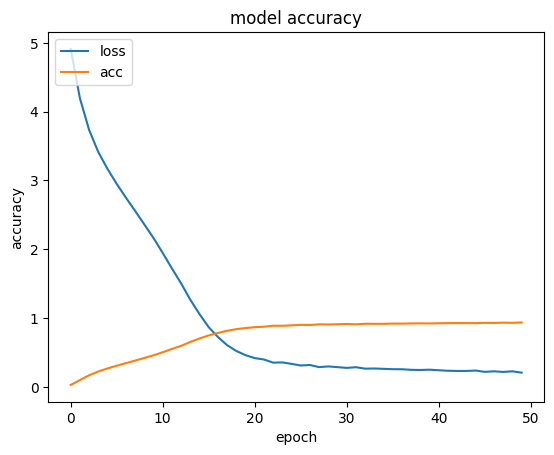

In [16]:
from matplotlib import pyplot as plt
#history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['final_loss'])
plt.plot(history.history['final_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'acc'], loc='upper left')
plt.show()

## Saving the trained model

In [17]:
# Save the model to models directory
if not os.path.exists('models'):
    os.mkdir("models")
model.save(os.path.join('models', 'inception_v1_base.h5'))

## Get test accuracy of the trained model

In [18]:
# Section 6.4

# Load the model from disk
model = load_model(os.path.join('models','inception_v1_base.h5'))

# Evaluate the model
test_res = model.evaluate(test_gen_aux, steps=get_steps_per_epoch(500*50, batch_size))

# Print the results as a dictionary {<metric name>: <value>}
test_res_dict = dict(zip(model.metrics_names, test_res))
print(test_res_dict)

196/196 [==============================] - 56s 280ms/step - loss: 27.5944 - final_loss: 8.1725 - aux1_loss: 10.2609 - aux2_loss: 9.1610 - final_accuracy: 0.2710 - aux1_accuracy: 0.2435 - aux2_accuracy: 0.2391
{'loss': 27.594390869140625, 'final_loss': 8.17249584197998, 'aux1_loss': 10.260876655578613, 'aux2_loss': 9.161019325256348, 'final_accuracy': 0.2710344195365906, 'aux1_accuracy': 0.24352477490901947, 'aux2_accuracy': 0.23906049132347107}
